ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    name = 'NINST'; format = '3J'
    name = 'NVISITS'; format = 'J'
    name = 'COMBTYPE'; format = 'J'
    name = 'COMMISS'; format = 'I'
    name = 'SNR'; format = 'E'
    name = 'STARFLAG'; fo

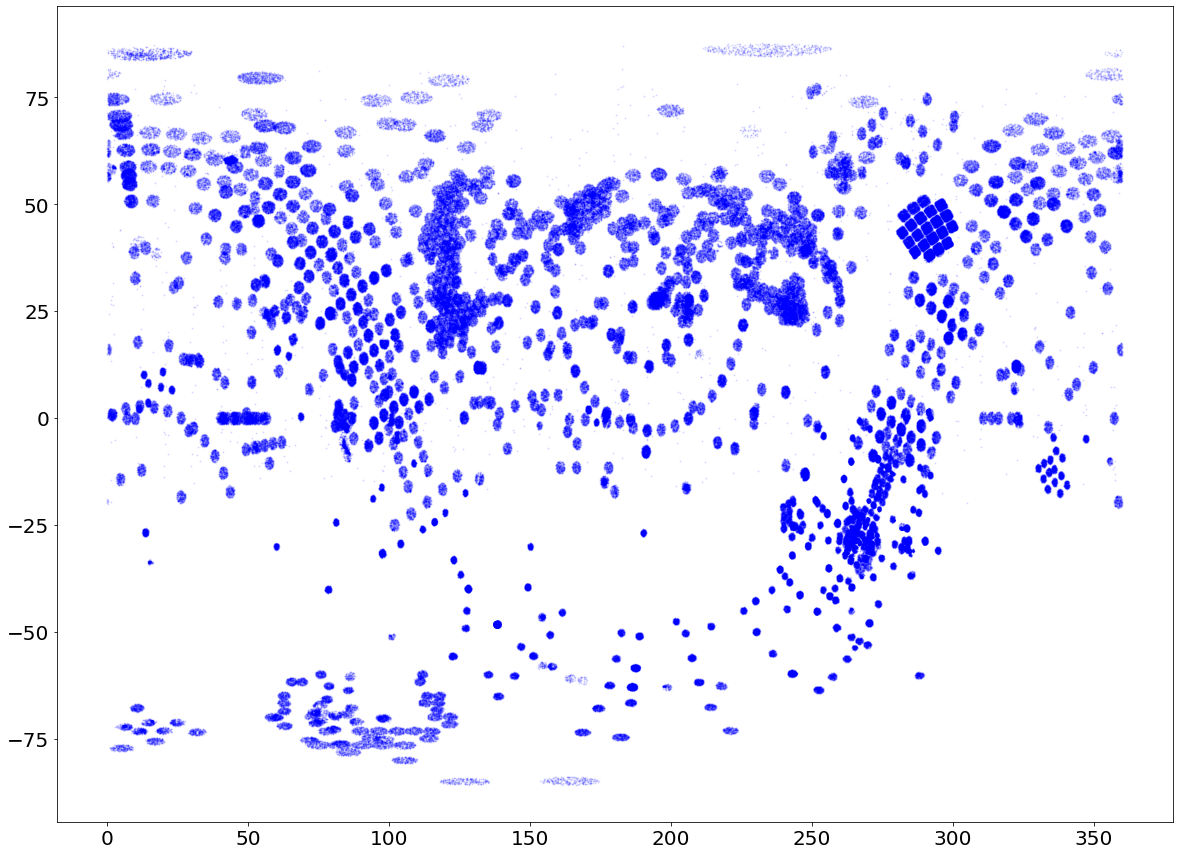

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gausian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('/home/jovazquez2000/Downloads/allStarLite-r12-l33_(1).fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

$ \sigma_{tot} = \sqrt{\sigma_1^2 + \sigma_2^2}$

In [70]:
def McFit(function,x,y,x_err,y_err):
    a = list()
    b = list()
    c = list()
    d = list()
    it = []
    iters = 500 
    if function == linear or function == gausian:
        for i in range(iters):
            # remember random normal distribution (Gaussian)
            weights = np.random.randn(len(y))

            y_adj = y + y_err*weights
            x_adj = x + x_err*weights 

            params, other = opt.curve_fit(function, x_adj, y_adj)
            a.append(params[0])
            b.append(params[1])
        return a,b
    elif function == poly2 or function == lorentzian_cauchy:
        for i in range(iters):
            # remember random normal distribution (Gaussian)
            weights = np.random.randn(len(y))

            y_adj = y + y_err*weights
            x_adj = x + x_err*weights 

            params, other = opt.curve_fit(function, x_adj, y_adj)
            a.append(params[0])
            b.append(params[1])
            c.append(params[2])
            
            
        return a,b,c
    elif function == poly3 or function == sigmoid or function == cosfit or function == exponential:
        for i in range(iters):
            # remember random normal distribution (Gaussian)
            weights = np.random.randn(len(y))

            y_adj = y + y_err*weights
            x_adj = x + x_err*weights 

            params, other = opt.curve_fit(function, x_adj, y_adj)
            a.append(params[0])
            b.append(params[1])
            c.append(params[2])
            d.append(params[3])
            
        return a,b,c,d


In [4]:
GLATmask = abs(star['GLAT']) <=1
TEFF = star['TEFF'][GLATmask]
TEFF_ERR = star['TEFF_ERR'][GLATmask]
LogG_ERR = star['LOGG_ERR'][GLATmask]
LogG = star['LOGG'][GLATmask]

loggmask = LogG > -9900
TEFF = TEFF[loggmask]
LogG = LogG[loggmask]
LogG_ERR = LogG_ERR[loggmask]
TEFF_ERR = TEFF_ERR[loggmask]

teffmask = TEFF > 0
TEFF = TEFF[teffmask]
LogG = LogG[teffmask]
LogG_ERR = LogG_ERR[teffmask]
TEFF_ERR = TEFF_ERR[teffmask]

Slope = 672.101; Std = 0.766


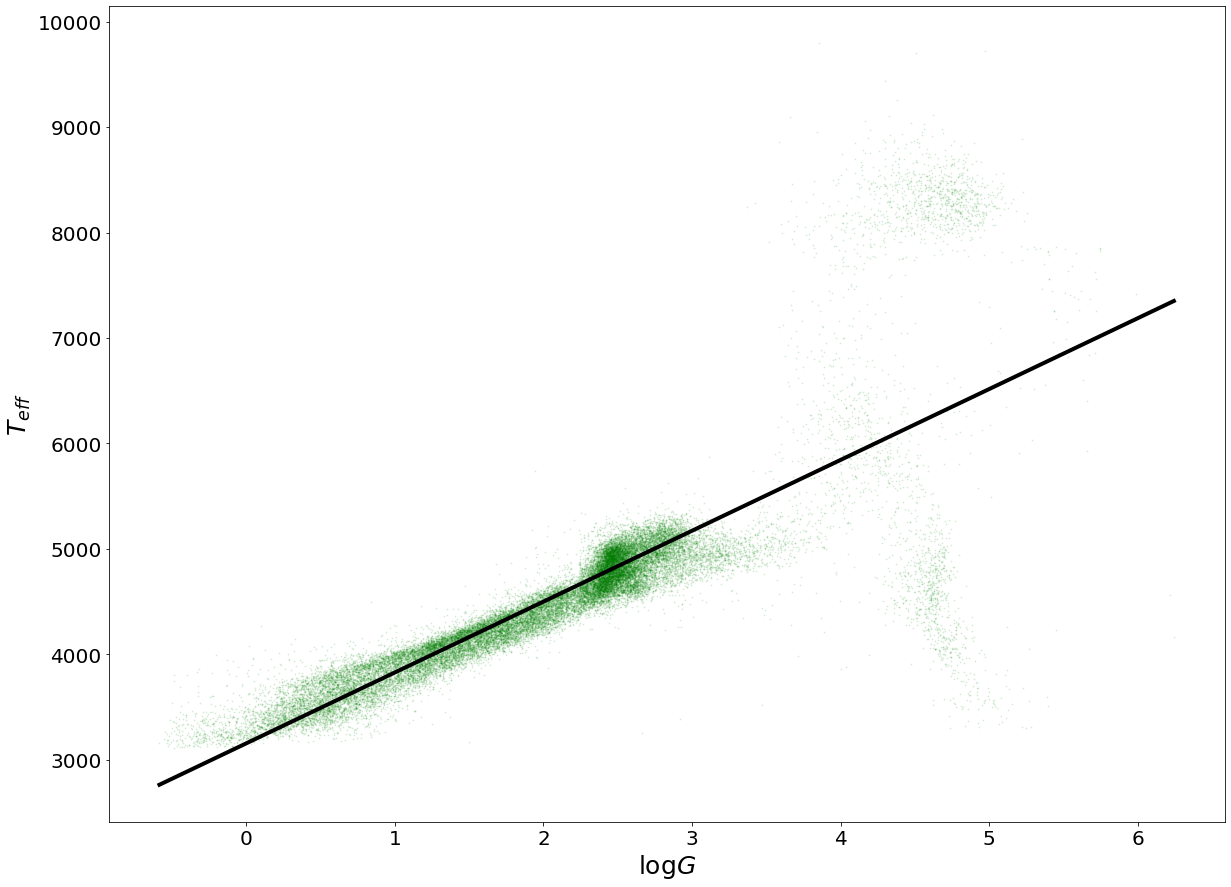

In [14]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(LogG,TEFF,s=1,c='g',alpha=0.1)
popt = McFit(linear,LogG,TEFF,x_err=LogG_ERR,y_err=TEFF_ERR)
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))

plt.plot()
logg = np.linspace(min(LogG),max(LogG),500)
plt.plot(logg,linear(logg,*poptavg),'k',linewidth=4.)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
print("Slope = %.3f; Std = %.3f" % (poptavg[0],np.std(popt[0])))
plt.xlabel('$\log{G}$',fontsize=25)
plt.ylabel(r'$T_{eff}$', fontsize=25)
#plt.axis(ymin=0)
plt.show()

In [6]:
GLATmask = abs(star['GLAT']) >= 10
#TEFF = star['TEFF'][good]
FE_H = star['FE_H'][GLATmask]
FE_H_ERR = star['FE_H_ERR'][GLATmask]
O_FE_ERR = star['O_FE_ERR'][GLATmask]
#LogG = star['LOGG'][good]
O_FE = star['O_FE'][GLATmask]

fehmask = FE_H > -9990
FE_H_ERR = FE_H_ERR[fehmask]
O_FE_ERR = O_FE_ERR[fehmask]
FE_H = FE_H[fehmask]
O_FE = O_FE[fehmask]

ofemask = O_FE > -9990
FE_H = FE_H[ofemask]
O_FE = O_FE[ofemask]
FE_H_ERR = FE_H_ERR[ofemask]
O_FE_ERR = O_FE_ERR[ofemask]

ofe = np.linspace(min(O_FE),max(O_FE),len(O_FE))

Slope = -0.081; Std = 0.00037098


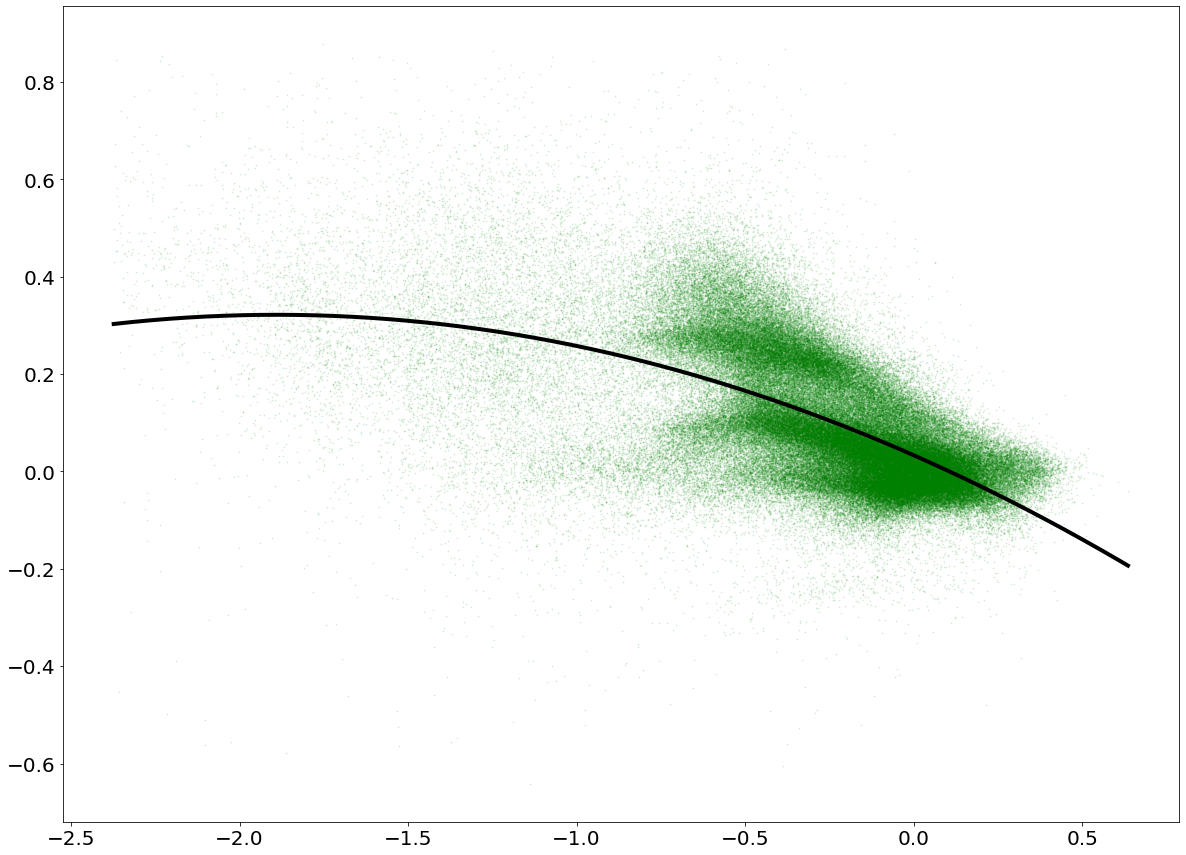

In [16]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(FE_H,O_FE,s=1,c='g',alpha=0.1)
popt = McFit(poly2,FE_H,O_FE,x_err=FE_H_ERR,y_err=O_FE_ERR)
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))

plt.plot()
feh = np.linspace(min(FE_H),max(FE_H),500)
plt.plot(feh,poly2(feh,*poptavg),'k',linewidth=4.)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
print("Slope = %.3f; Std = %.8f" % (poptavg[0],np.std(popt[0])))

#plt.axis(ymin=0)
#plt.show()

In [17]:
GLATmask = abs(star['GLAT']) <= 2
#TEFF = star['TEFF'][good]
FE_H = star['FE_H'][GLATmask]
FE_H_ERR = star['FE_H_ERR'][GLATmask]
O_FE_ERR = star['O_FE_ERR'][GLATmask]
#LogG = star['LOGG'][good]
O_FE = star['O_FE'][GLATmask]

fehmask = FE_H > -9990
FE_H_ERR = FE_H_ERR[fehmask]
O_FE_ERR = O_FE_ERR[fehmask]
FE_H = FE_H[fehmask]
O_FE = O_FE[fehmask]

ofemask = O_FE > -9990
FE_H = FE_H[ofemask]
O_FE = O_FE[ofemask]
FE_H_ERR = FE_H_ERR[ofemask]
O_FE_ERR = O_FE_ERR[ofemask]

ofe = np.linspace(min(O_FE),max(O_FE),len(O_FE))

Slope = -0.161; Std = 0.00036669


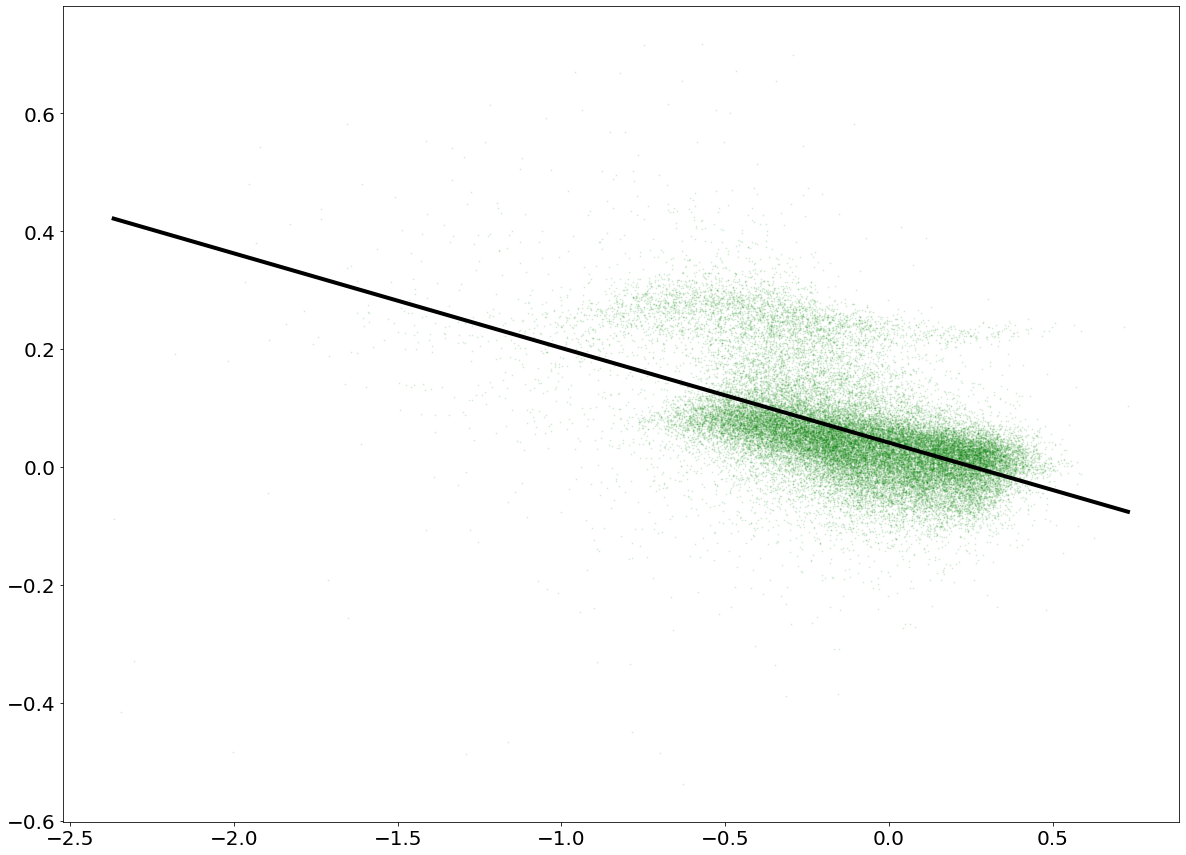

In [19]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(FE_H,O_FE,s=1,c='g',alpha=0.1)
popt = McFit(linear,FE_H,O_FE,x_err=FE_H_ERR,y_err=O_FE_ERR)
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))

plt.plot()
feh = np.linspace(min(FE_H),max(FE_H),500)
plt.plot(feh,linear(feh,*poptavg),'k',linewidth=4.)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
print("Slope = %.3f; Std = %.8f" % (poptavg[0],np.std(popt[0])))
plt.xlabel("$FE_H$")
plt.ylabel("O_{FE}")
#plt.axis(ymin=0)
#plt.show()

In [20]:
GLATmask = abs(star['GLAT']) >= 10
#TEFF = star['TEFF'][good]
J = star['J'][GLATmask]
K = star['K'][GLATmask]
JKSIGMA = ((star['J_ERR'][GLATmask])**2 + (star['K_ERR'][GLATmask])**2)**(1./2)
TEFF = star['TEFF'][GLATmask]
TEFF_ERR = star['TEFF_ERR'][GLATmask]

teffmask = TEFF > 0
J = J[teffmask]
K = K[teffmask]
JKSIGMA = JKSIGMA[teffmask]
TEFF = TEFF[teffmask]
TEFF_ERR = TEFF_ERR[teffmask]

jmask = (J>-9990)
J = J[jmask]
K = K[jmask]
TEFF = TEFF[jmask]
JKSIGMA = JKSIGMA[jmask]
TEFF_ERR = TEFF_ERR[jmask]

kmask = K>-9990
J = J[kmask]
K = K[kmask]
TEFF = TEFF[kmask]
JKSIGMA = JKSIGMA[kmask]
TEFF_ERR = TEFF_ERR[kmask]


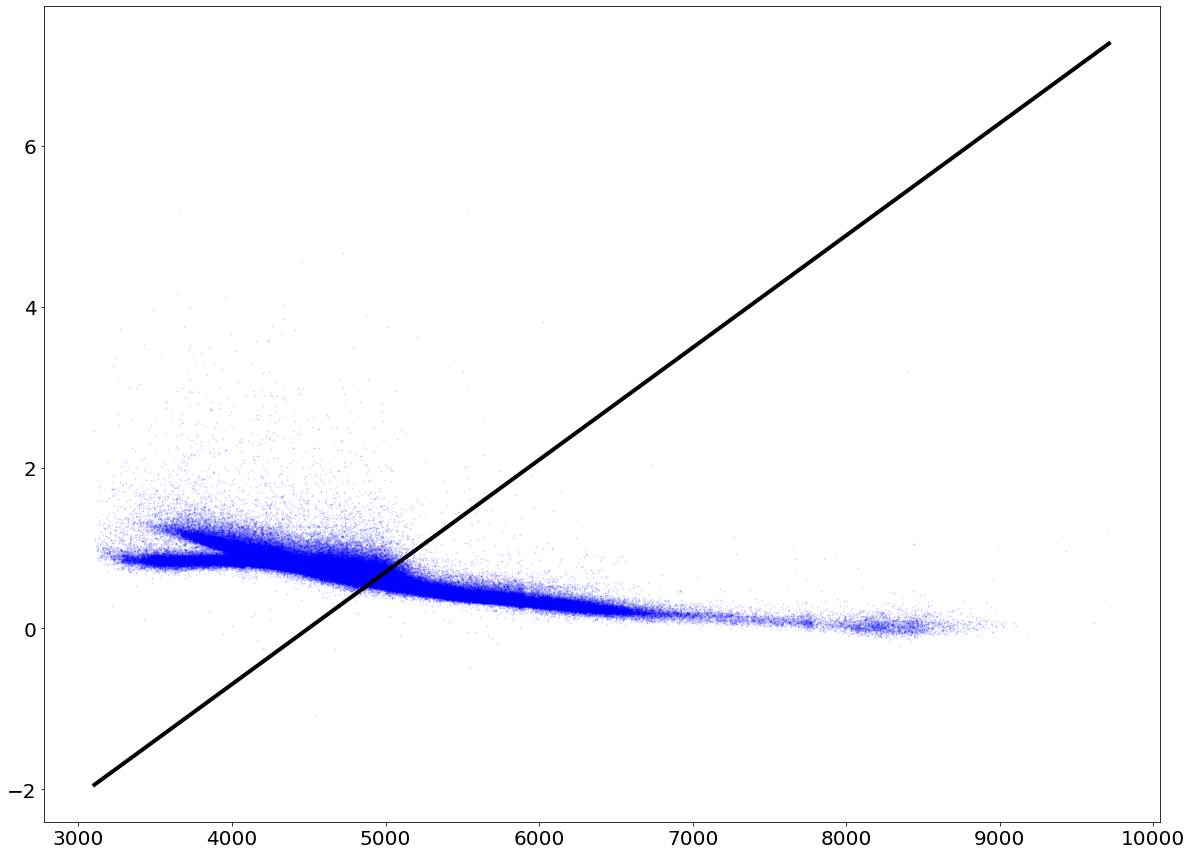

In [37]:
fig = plt.figure(figsize=(20,15))
popt = McFit(linear,x=TEFF,y=(J-K),y_err = JKSIGMA, x_err=TEFF_ERR)
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))
ax = fig.add_subplot(111)
teff = np.linspace(min(TEFF),max(TEFF),500)
ax.scatter(TEFF,(J-K),s=1,c='b',alpha=0.1)
ax.plot(teff,linear(teff,*poptavg),'k',linewidth=4.)
#popt,pcov = opt.curve_fit(poly3,TEFF,(J-K))
plt.plot()

#plt.plot(ofe,poly3(ofe,*popt))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
#plt.axis(xmin=-2.5,xmax=2.5)
plt.show()

In [46]:
GLATmask = abs(star['GLAT']) >= 10
#TEFF = star['TEFF'][good]
GLON = star['GLON'][GLATmask]
VHELIO_AVG = star['VHELIO_AVG'][GLATmask]
VERR = star['VERR'][GLATmask]

vheliomask = VHELIO_AVG <= 999998.
GLON = GLON[vheliomask]
VHELIO_AVG = VHELIO_AVG[vheliomask]
VERR = VERR[vheliomask]

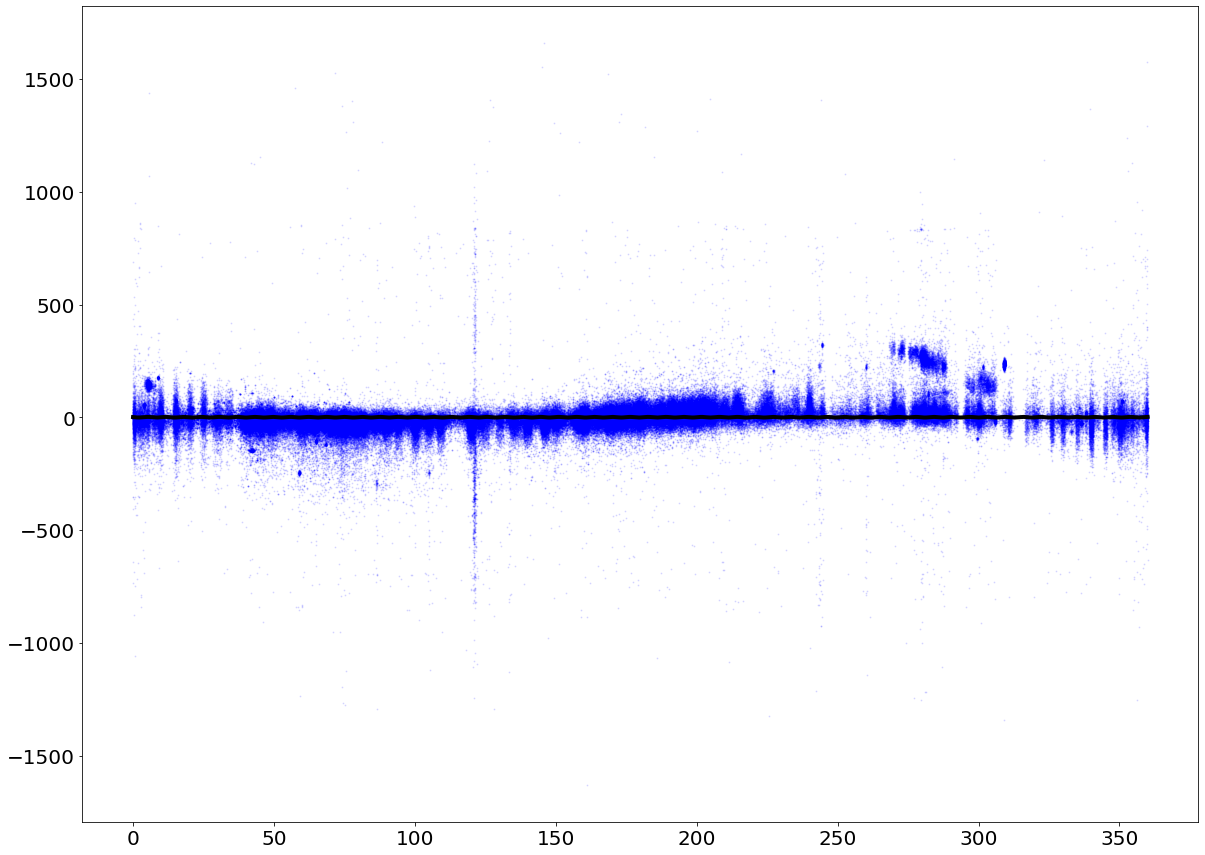

In [56]:
fig = plt.figure(figsize=(20,15))
popt = McFit(cosfit,x=GLON,y=VHELIO_AVG,y_err = VERR,x_err = np.zeros(len(VERR)))
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))
ax = fig.add_subplot(111)
glon = np.linspace(min(GLON),max(GLON),500)
ax.scatter(GLON,VHELIO_AVG,s=1,c='b',alpha=0.1)
ax.plot(glon,cosfit(glon,*poptavg),'k',linewidth=4.)
#popt,pcov = opt.curve_fit(poly3,TEFF,(J-K))
plt.plot()

#plt.plot(ofe,poly3(ofe,*popt))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
#plt.axis(xmin=-2.5,xmax=2.5)
plt.show()

In [59]:
GLATmask = abs(star['GLAT']) >= 10
#TEFF = star['TEFF'][good]
NVISITS = star['NVISITS'][GLATmask]
VSCATTER = star['VSCATTER'][GLATmask]
VERR = star['VERR'][GLATmask]

nvisitsmask = NVISITS >= 1.
NVISITS = NVISITS[nvisitsmask]
VSCATTER = VSCATTER[nvisitsmask]
VERR = VERR[nvisitsmask]

vscattermask = VSCATTER <= 999998.
NVISITS = NVISITS[vscattermask]
VSCATTER = VSCATTER[vscattermask]
VERR = VERR[vscattermask]

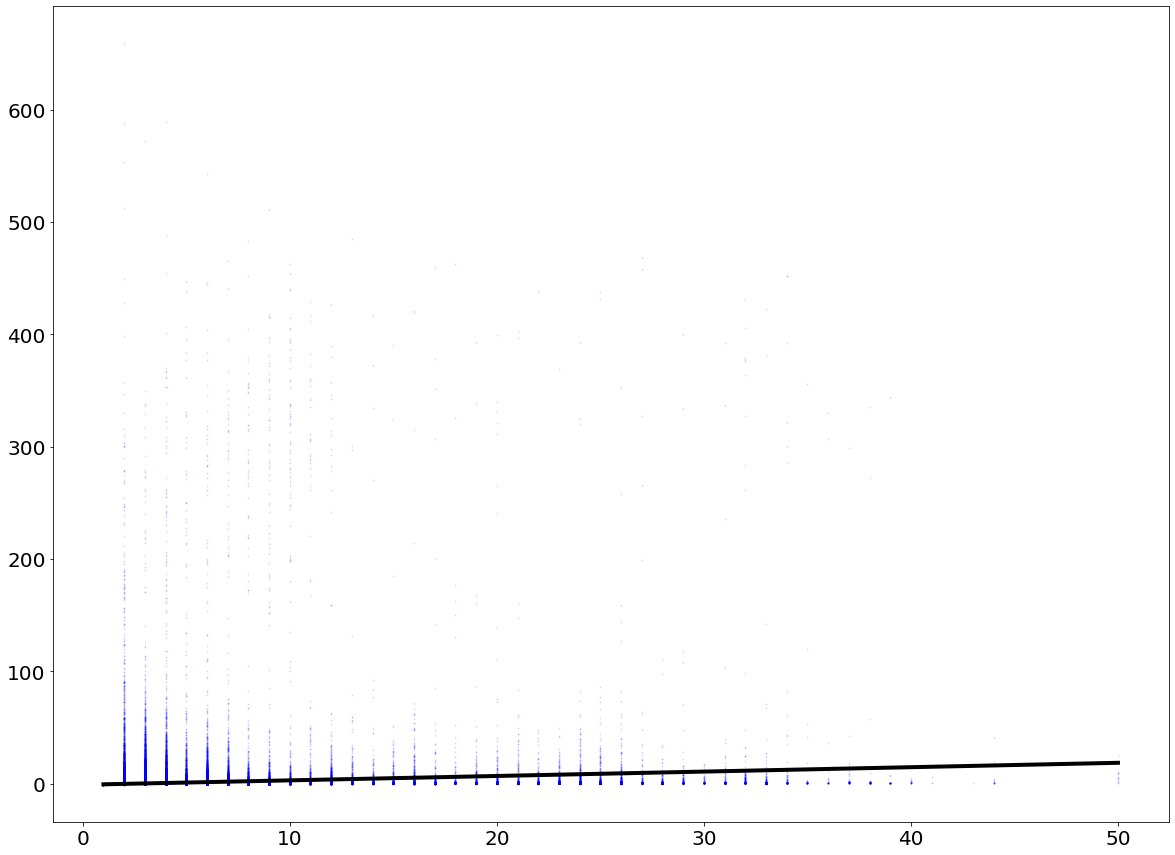

In [72]:
fig = plt.figure(figsize=(20,15))
popt = McFit(linear,x=NVISITS,y=VSCATTER,y_err = VERR,x_err = np.zeros(len(VERR)))
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))
ax = fig.add_subplot(111)
nvisits = np.linspace(min(NVISITS),max(NVISITS),500)
ax.scatter(NVISITS,VSCATTER,s=1,c='b',alpha=0.1)
ax.plot(nvisits,linear(nvisits,*poptavg),'k',linewidth=4.)
#popt,pcov = opt.curve_fit(poly3,TEFF,(J-K))
plt.plot()

#plt.plot(ofe,poly3(ofe,*popt))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
#plt.axis(xmin=-2.5,xmax=2.5)
plt.show()

In [75]:
GLATmask = abs(star['GLAT']) >= 10
FE_H = star['FE_H']
NI_FE = star['NI_FE']

FE_H = FE_H[GLATmask]
NI_FE = NI_FE[GLATmask]
FE_H_ERR = star['FE_H_ERR'][GLATmask]
NI_FE_ERR = star['NI_FE_ERR'][GLATmask]

fehmask = FE_H > -9998.

FE_H = FE_H[fehmask]
NI_FE = NI_FE[fehmask]
FE_H_ERR = FE_H_ERR[fehmask]
NI_FE_ERR = NI_FE_ERR[fehmask]

nifemask = NI_FE > -9998.


FE_H = FE_H[nifemask]
NI_FE = NI_FE[nifemask]
FE_H_ERR = FE_H_ERR[nifemask]
NI_FE_ERR = NI_FE_ERR[nifemask]

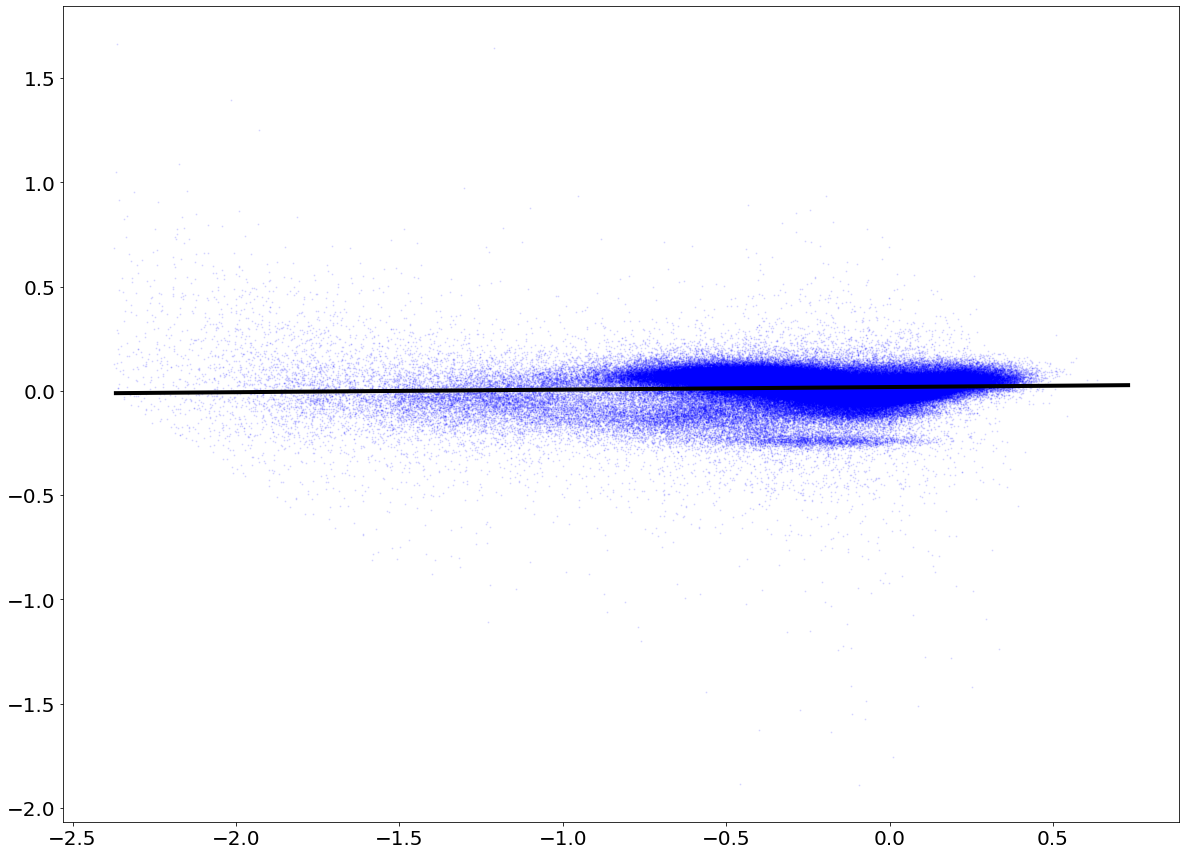

In [77]:
fig = plt.figure(figsize=(20,15))
popt = McFit(linear,x=FE_H,y=NI_FE,y_err = NI_FE_ERR,x_err = FE_H_ERR)
popt = np.array(popt)
poptavg = []
for arr in popt:
    poptavg.append(np.average(arr))
ax = fig.add_subplot(111)
feh = np.linspace(min(feh),max(feh),500)
ax.scatter(FE_H,NI_FE,s=1,c='b',alpha=0.1)
ax.plot(feh,linear(feh,*poptavg),'k',linewidth=4.)
#popt,pcov = opt.curve_fit(poly3,TEFF,(J-K))
plt.plot()

#plt.plot(ofe,poly3(ofe,*popt))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
#plt.axis(xmin=-2.5,xmax=2.5)
plt.show()